# Proyek Klasifikasi Gambar: APPLE
- **Nama:** Gerin Sena Pratama
- **Email:** denapratama7@gmail.com
- **ID Dicoding:** gerindenapratama

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflow==2.15
!pip install gdown
!apt-get install unrar
!pip install rarfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import gdown
import rarfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras import layers, regularizers, models, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import pathlib

## Data Preparation

### Data Loading

In [3]:
# URL file dari Google Drive
file_url = 'https://drive.google.com/uc?id=1nkUqvsfprtJ7KfXFyiP7OrButSPVCUcW'  # Ubah 'view?usp=sharing' menjadi 'uc?id='
output = 'dataset.rar'
gdown.download(file_url, output, quiet=False)

# Ekstrak file rar
file_path = 'dataset.rar'
output_dir = 'dataset/'  # Folder tujuan hasil ekstraksi

with rarfile.RarFile(file_path) as rf:
    rf.extractall(output_dir)

print("Ekstraksi selesai!")

Downloading...
From (original): https://drive.google.com/uc?id=1nkUqvsfprtJ7KfXFyiP7OrButSPVCUcW
From (redirected): https://drive.google.com/uc?id=1nkUqvsfprtJ7KfXFyiP7OrButSPVCUcW&confirm=t&uuid=00e5ff5e-44f1-4172-8bcf-83dd270c3931
To: /content/dataset.rar
100%|██████████| 43.7M/43.7M [00:00<00:00, 50.9MB/s]


Ekstraksi selesai!


In [4]:
# Tentukan path ke folder dataset
dataset_path = 'dataset/apple/'

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(dataset_path)


Apple Golden 3: 642
- (100, 100)
---------------
Apple Golden 2: 656
- (100, 100)
---------------
Apple Red 2: 656
- (100, 100)
---------------
Apple Red Delicious 1: 656
- (100, 100)
---------------
Apple Pink Lady 1: 608
- (100, 100)
---------------
Apple Granny Smith 1: 656
- (100, 100)
---------------
Apple hit 1: 936
- (100, 100)
---------------
Apple Braeburn 1: 656
- (100, 100)
---------------
Apple Red 3: 573
- (100, 100)
---------------
Apple 6: 630
- (100, 100)
---------------
Apple Red Yellow 2: 891
- (100, 100)
---------------
Apple Golden 1: 640
- (100, 100)
---------------
Apple Red 1: 656
- (100, 100)
---------------
Apple Crimson Snow 1: 592
- (100, 100)
---------------
Apple Red Yellow 1: 656
- (100, 100)
---------------

Total: 10104


### Data Preprocessing

#### Split Dataset

In [15]:
# ImageDataGenerator untuk normalisasi dan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Dataset training (80% dari total dataset)
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(100, 100),  # Sesuaikan dengan ukuran gambar Animals 10
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training',  # Menggunakan subset untuk training
)

# Dataset validation (20% dari total dataset)
validation_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(100, 100),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='validation',  # Menggunakan subset untuk validation
)

Found 8087 images belonging to 15 classes.
Found 2017 images belonging to 15 classes.


## Modelling

In [16]:
class StopTrainingAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.95):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # Mengecek akurasi training dan validasi pada akhir setiap epoch
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc >= self.target_accuracy and val_acc >= self.target_accuracy:
            print(f"\nTarget tercapai: Akurasi Training={train_acc:.4f}, Validasi={val_acc:.4f}. Stop training.")
            self.model.stop_training = True

In [17]:
# Membersihkan sesi sebelumnya
tf.keras.backend.clear_session()

model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(15, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
stop_training = [StopTrainingAtAccuracy(target_accuracy=0.95)]

# latih model dengan model.fit
history = model.fit(
      train_generator,
      epochs=20, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      callbacks=[early_stopping, reduce_lr, stop_training],
      batch_size=32,
      verbose=1)

Epoch 1/20
253/253 [==============================] - 35s 131ms/step - loss: 2.0446 - accuracy: 0.3611 - val_loss: 1.0064 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 2/20
253/253 [==============================] - 29s 116ms/step - loss: 0.8416 - accuracy: 0.7512 - val_loss: 0.9138 - val_accuracy: 0.6901 - lr: 0.0010
Epoch 3/20
253/253 [==============================] - 29s 115ms/step - loss: 0.5161 - accuracy: 0.8765 - val_loss: 0.5350 - val_accuracy: 0.9256 - lr: 0.0010
Epoch 4/20
253/253 [==============================] - 30s 120ms/step - loss: 0.4237 - accuracy: 0.9060 - val_loss: 0.3453 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 5/20
253/253 [==============================] - 29s 117ms/step - loss: 0.3295 - accuracy: 0.9377 - val_loss: 0.5169 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 6/20
253/253 [==============================] - 30s 118ms/step - loss: 0.3061 - accuracy: 0.9462 - val_loss: 0.5447 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 7/20
253/253 [==============================] 

## Evaluasi dan Visualisasi

64/64 [==============================] - 2s 26ms/step - loss: 0.3948 - accuracy: 0.9504
Validation Loss: 0.3948497772216797
Validation Accuracy: 0.9504213929176331


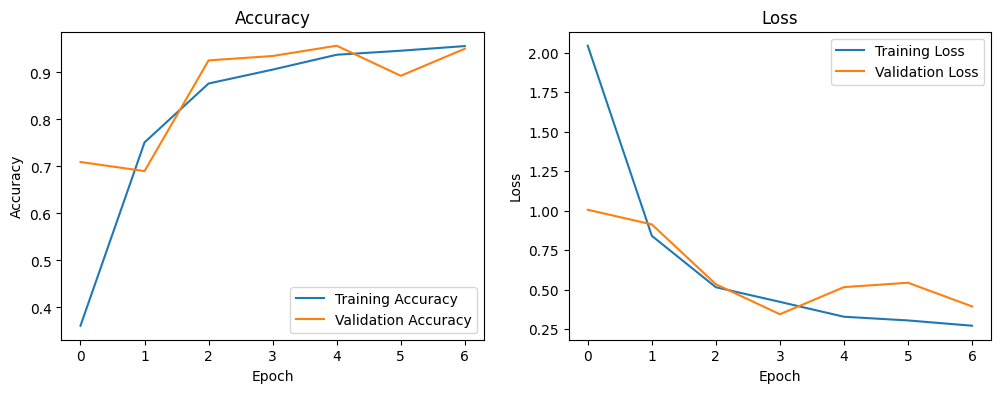

In [18]:
# Evaluasi model pada data validation
validation_loss, validation_accuracy = model.evaluate(validation_generator)

print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Konversi Model

In [19]:
# save model
model.save("model.h5")

!pip install tensorflowjs

# konversi ke tensorflowjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


2024-10-21 12:45:36.467515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:45:36.489051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:45:36.495364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:45:37.573403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
# konversi ke format saved model
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7c3f9cf01990>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7c3f9cf01990>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Layer._handle_weight_regularization.<locals>._loss_for_variable at 0x7c400a3fbd00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Layer._handle_weight_regularization.<locals>._loss_for_variable at 0x7c400a3fbd00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [21]:
# konversi ke tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

## Inference (Optional)

Saving 0_100.jpg to 0_100 (3).jpg
Predicted class: Apple Braeburn 1 (Confidence: 99.83%)


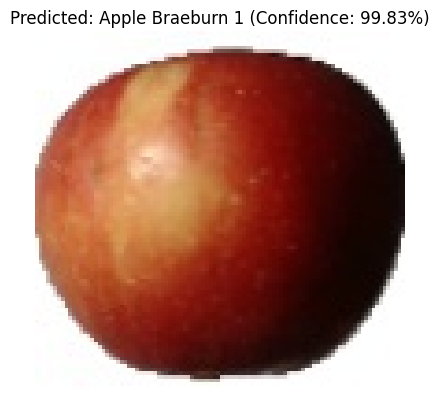

In [26]:
# Upload file gambar
uploaded = files.upload()

# Ambil path dari gambar yang di-upload
img_path = list(uploaded.keys())[0]

# Load dan resize gambar (disesuaikan dengan input model)
img = load_img(img_path, target_size=(100, 100))
img_array = img_to_array(img) / 255.0  # Normalisasi [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

# Load model menggunakan tf.saved_model.load
model = tf.saved_model.load('saved_model/')
infer = model.signatures["serving_default"]

# Pastikan input dalam format tensor dan lakukan prediksi
output = infer(tf.constant(img_array))

# Akses output (pastikan key-nya sesuai)
predictions = output['dense_1'].numpy()  # Sesuaikan dengan key output

# Ambil indeks kelas dengan argmax dan confidence
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = predictions[0][predicted_class]

# Dapatkan mapping nama kelas dari train_generator
class_indices = train_generator.class_indices  # Misal dari ImageDataGenerator
label_map = {v: k for k, v in class_indices.items()}  # Balik key dan value

# Ambil nama kelas berdasarkan indeks
predicted_label = label_map.get(predicted_class, "Unknown")

# Output hasil prediksi
print(f'Predicted class: {predicted_label} (Confidence: {confidence * 100:.2f}%)')

# Tampilkan gambar yang di-upload
plt.imshow(img)
plt.axis('off')  # Matikan sumbu
plt.title(f'Predicted: {predicted_label} (Confidence: {confidence * 100:.2f}%)')
plt.show()

In [27]:
!pip freeze > requirements.txt